# Open TODOs

In [134]:
#TODO: Cleaning of news data
#Extra cleaning on the news data? 
#Clean out bad articles

#TODO: Long.Short Name Conversion
#Long name to many short names

#TODO: Article analysis on number of false positives
#Look at how articles mention each c
# ompany 
#Eyeball false positive to true positives 
#False positives -> Create manual labels 

#TODO: NEgative Examples
#Negative Examples
#Negative example from articles that mentions company A from KB and any entity recognised by spaCy
#Use spacy tags to create negative examples?

#TODO: More Spacy Integration and Language Model Integration
#Use cusutom tokenizier instead of regex to match entities
#E.g. Spacy POS Tags to be used as features
#Figure out where inthe process a large language model would fit

# Import Libraries 
Changing Path to import nlp functions

In [1]:
import json
import os
import re
import time
import gzip
import itertools


import sys
import numpy as np
import pandas as pd

# from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import spacy
from spacy.matcher import PhraseMatcher


try:
    # python package (nlp) location - two levels up from this file
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
    # add package to sys.path if it's not already there
    if src_path not in sys.path:
        sys.path.extend([src_path])
except NameError:
    print('issue with adding to path, probably due to __file__ not being defined')
    src_path = None
    
from nlp.utils import get_database
from nlp import get_configs_path, get_data_path

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function Definitions

In [2]:
def find_all_articles_with_name(articles, name):
    return [v for k, v in articles.items() if re.search(name, v["maintext"])]


def remove_suffix(name, suffixes):
    for s in suffixes:
        # regex: space, word, space then any character to end
        # or
        name = re.sub(f" {s} .*$| {s}$", "", name)
    return name


def get_start_end(a, b, aname="a", bname="b"):

    assert len(np.intersect1d(a, b)) == 0, f"some elements found in both 'a' and 'b'"

    c = np.sort(np.concatenate([a, b]))
    is_a = np.in1d(c, a)

    res = []
    names = []
    for i in range(len(c)-1):
        if is_a[i] != is_a[i+1]:
            res.append((c[i], c[i+1]))
            if is_a[i]:
                names.append((aname, bname))
            else:
                names.append((bname, aname))

    return res, names

# Load the data

## Connect to MongoDB

In [3]:
# get credentials
with open(get_configs_path("mongo.json"), "r+") as f:
    mdb_cred = json.load(f)

# get mongodb client - for connections
client = get_database(username=mdb_cred["username"],
                        password=mdb_cred["password"],
                        clustername=mdb_cred["cluster_name"])


## Load News Data

In [4]:
#Parameter:
read_local_articles = False

# ----
# read the articles in
# ----

if read_local_articles:
    # read proof of concept data
    with open(get_data_path("articles.json"), "r") as f:
        article_list = json.load(f)

    #
    articles = {re.sub("\.json$", "", f["json_file"]): f
                for f in article_list if "names_in_text" in f}

else:
    # instead, read (a larger) set of articles from mongo
    # - this can be quite large
    # because taking 'names_in_text' this might not be everything
    articles = {re.sub("\.json$", "", f["json_file"]): f
                for f in client["news_articles"]["articles"].find({'names_in_text': {"$exists": True}})}

keys = list(articles.keys())

print(f"read in: {len(keys)} articles")

read in: 81275 articles


In [145]:
#TODO: Connect to DB to load latest mapping 
print(f"database names: {client.list_database_names()}")




long_short_conversion = {f['long_name']:f['short_names'] for f in client['news_articles']["long_to_short_name"].find()}

database names: ['news_articles', 'knowledge_base', 'test', 'admin', 'local']


In [146]:
long_short_conversion

{'3M Co': ['3M'],
 '8x8 Inc': ['8x8'],
 'A123 Systems Inc': ['A123'],
 'AAC Technologies Holdings Inc': ['AAC'],
 'AMC Networks Inc': ['AMC'],
 'ANA Holdings Inc': ['ANA'],
 'ASML Holding NV': ['ASML'],
 'AT&T Inc': [],
 'AU Optronics Corp': ['AU Optronics'],
 'Abu Dhabi National Oil Co': ['ADNOC'],
 'Accenture PLC': ['Accenture'],
 'Acer Inc': ['Acer'],
 'Activision Blizzard Inc': ['Activision'],
 'Adamis Pharmaceuticals Corp': ['Adamis'],
 'Adobe Inc': ['Adobe'],
 'Advanced Micro Devices Inc': ['AMD'],
 'Advantest Corp': [],
 'Adyen NV': ['Adyen'],
 'Aeon Co Ltd': ['Aeon'],
 'AerCap Holdings NV': [],
 'Aerojet Rocketdyne Holdings Inc': ['Aerojet Rocketdyne', 'Aerojet'],
 'Aeva Inc': ['Aeva'],
 'Agilent Technologies Inc': ['Agilent'],
 'Aimia Inc': ['Aimia'],
 'Air Canada': ['Air Canada'],
 'Air Canada Pilots Association': ['ACPA'],
 'Air China Ltd': [],
 'Air France KLM SA': [],
 'Air India Ltd': [],
 'Air Lease Corp': [],
 'Air New Zealand Ltd': [],
 'Air Products and Chemicals Inc'

In [144]:
long_short_conversion

[{'_id': ObjectId('622a48d9ba81d7a19f9400ba'),
  'long_name': '3M Co',
  'short_names': ['3M']},
 {'_id': ObjectId('622a48d9ba81d7a19f9400bb'),
  'long_name': '8x8 Inc',
  'short_names': ['8x8']},
 {'_id': ObjectId('622a48d9ba81d7a19f9400bc'),
  'long_name': 'A123 Systems Inc',
  'short_names': ['A123']},
 {'_id': ObjectId('622a48d9ba81d7a19f9400bd'),
  'long_name': 'AAC Technologies Holdings Inc',
  'short_names': ['AAC']},
 {'_id': ObjectId('622a48d9ba81d7a19f9400be'),
  'long_name': 'AMC Networks Inc',
  'short_names': ['AMC']},
 {'_id': ObjectId('622a48d9ba81d7a19f9400bf'),
  'long_name': 'ANA Holdings Inc',
  'short_names': ['ANA']},
 {'_id': ObjectId('622a48d9ba81d7a19f9400c0'),
  'long_name': 'ASML Holding NV',
  'short_names': ['ASML']},
 {'_id': ObjectId('622a48d9ba81d7a19f9400c1'),
  'long_name': 'AT&T Inc',
  'short_names': []},
 {'_id': ObjectId('622a48d9ba81d7a19f9400c2'),
  'long_name': 'AU Optronics Corp',
  'short_names': ['AU Optronics']},
 {'_id': ObjectId('622a48d9ba

### Some Exploratory Analysis

In [6]:
#Pulling one Article from the Database 
articles[list(articles.keys())[0]]

{'_id': ObjectId('620d7157c02377e1232d8ed7'),
 'authors': ['Reuters Editorial', 'Reuters Staff'],
 'date_download': '2018-03-20 02:27:54+00:00',
 'date_modify': None,
 'date_publish': '2018-03-19 11:41:38',
 'description': 'Oil giant Saudi Aramco is looking to buy a majority stake in a proposed refinery and petrochemical complex valued at 3 trillion rupees ($46.10 billion) in the western Indian state of Maharashtra, local daily Economic Times reported, citing people familiar with the matter.',
 'filename': 'https%3A%2F%2Fwww.reuters.com%2Farticle%2Fus-saudiaramco-india%2Fsaudi-aramco-seeks-majority-stake-in-indian-refinery-economic-times-idUSKBN1GV1B3.json',
 'image_url': 'https://s4.reutersmedia.net/resources/r/?m=02&d=20180319&t=2&i=1242461315&w=1200&r=LYNXMPEE2I0T8',
 'language': 'en',
 'localpath': None,
 'maintext': '(Reuters) - Oil giant Saudi Aramco is looking to buy a majority stake in a proposed refinery and petrochemical complex valued at 3 trillion rupees ($46.10 billion) in

In [7]:
# #Check how many articles have the 'names_in_text attribute
# print("{} out of {} have the 'names in text' attribute".format(len(comp_lists),len(articles.keys())))

In [8]:
#Create a list of all the companies named in each article (This is a list of lists -> One list per article)
comp_lists = [articles[key]['names_in_text'] for key in articles.keys() if 'names_in_text' in articles[key].keys()]
#Crate one list that includes all companies in one list
comp_list = [company for comp_list in comp_lists for company in comp_list]
#Check how many company mentions we have in total
print("There are {} company mentions across all {} articles that have the names_in_text attribute".format(len(comp_list),len(comp_lists)))

There are 120852 company mentions across all 81275 articles that have the names_in_text attribute


In [9]:
#Check how many companies are mentioned by each article
num_comp_per_article = [len(comp_list) for comp_list in comp_lists]
num_comp_per_article_dict = Counter(num_comp_per_article)
num_comp_per_article_df = pd.DataFrame(num_comp_per_article_dict.values(),index=num_comp_per_article_dict.keys(),columns=["Number of Articles"]).sort_values("Number of Articles",ascending=False)
num_comp_per_article_df

,Number of Articles
1,58515
2,13464
3,5195
4,2380
5,924
6,407
7,198
8,94
9,39
10,24


In [10]:
#Check out which article is the one with 15 (!) company mentions
#Commented out because its a large print
#print([articles[key] for key in articles.keys() if 'names_in_text' in articles[key].keys() and len(articles[key]['names_in_text'])>14][0])

881


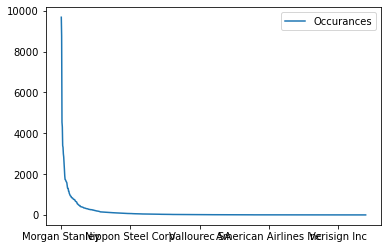

In [11]:
#Check which company is mentioned most frequently -> Classic Power Law distribution
comp_dict = Counter(comp_list)
comp_df = pd.DataFrame(comp_dict.values(), columns= ["Occurances"], index = comp_dict.keys()).sort_values('Occurances', ascending=False)
comp_df.plot()
comp_df.head(50)
print(comp_df.shape[0])

In [12]:
comp_df.head(50)

,Occurances
Morgan Stanley,9677
Apple Inc,8753
Boeing Co,4539
Amazon.com Inc,4303
Microsoft Corp,3398
General Motors Co,3305
Alphabet Inc,2987
Ford Motor Co,2836
Toyota Motor Corp,2574
Tesla Inc,2235


## Load Supply Chain Data
(Look at value_chain_data_exploration.ipnyb for more anlaysis on the graph)

In [5]:
# ---
# read in value chain data
# ---

vc = pd.DataFrame(list(client["knowledge_base"]["KB"].find(filter={})))
vc.head()


,_id,Parent Name,Parent Id,Identifier,Company Name,Type,Relationship,Country/Region,Industry,Confidence Score (%),Last Update Date,Days Since Last Update,Freshness,Snippet Count,Revenue (USD),EQ Score,Implied Rating,fetch_time
0,61ffc35c52e17d8ff84f5c3c,DS Smith PLC,4295894074,4295903247,Procter & Gamble Co,Public,Customer,United States of America,Personal Products,0.587784,2015-06-25,2416,1,3,7.611800e+10,89.0,BBB+,2022-02-04 11:10:00
1,61ffc2e552e17d8ff84f5c37,Seoul Semiconductor Co Ltd,4295882677,4295905573,Apple Inc,Public,Customer,United States of America,Phones & Handheld Devices,1.000000,2018-02-01,1465,2,1,3.658170e+11,80.0,A,2022-02-05 19:47:00
2,61ffc35c52e17d8ff84f5c41,Brightstar Corp,4296334059,4295877094,SoftBank Group Corp,Public,Customer,Japan,Wireless Telecommunications Services,0.630819,2014-01-16,2942,1,4,5.309997e+10,7.0,BB-,2022-02-05 20:25:00
3,61ffc35c52e17d8ff84f5c46,Brightstar Corp,4296334059,4295907020,Logility Inc,Private,Supplier,United States of America,IT Services & Consulting,0.290066,2018-05-15,1362,2,2,4.160300e+07,NaN,NaN,2022-02-05 20:25:00
4,61ffc35c52e17d8ff84f5c48,Navistar International Corp,4295904608,4295903829,Cummins Inc,Public,Supplier,United States of America,"Auto, Truck & Motorcycle Parts",0.999956,2021-05-20,259,5,23,1.981100e+10,90.0,BBB,2022-02-03 14:41:00


In [6]:
#Number of relationships
vc.shape[0]

21458

In [7]:
#Num of Parent Companies
len(vc['Parent Name'].unique())

572

# Processing the News Data

## Filter out articles with incorrect matches

In [8]:
#This will check for erroneous matches (Mobil Corp is matched for Exxon Mobile in other script, LifeLock and Oracle are also erroneously matched)
#Then remove all articles that have only 1 name in it as they will not help us in finding positive or negative samples

# get all names
all_names = np.unique(np.concatenate([v["names_in_text"]
                                        for k, v in articles.items()]))
# add a dash in names to have more explicit matching (?)
dash_names = {n: re.sub(" ", "-", n) for n in all_names}
dash_names
# for each article replace the name with the dashed name
# - the idea is this will help with tokenizing

not_found_list = []

names_in_text_dict = {}
for k in keys:
    a = articles[k]
    anames = np.array(a["names_in_text"])
    dnames = np.array([dash_names[an] for an in anames])
    # replace the longest matching first - to deal with
    name_len = [len(an) for an in anames]
    name_ord = np.argsort(name_len)[::-1]

    maintext = a["maintext"]
    name_in_article = []
    for an in anames[name_ord]:
        if re.search(an, maintext):
            # get the new-names  in article
            name_in_article.append(an)
            maintext = re.sub(an, dash_names[an], maintext)
        else:
            # print(f"could not find: {an} in {k}")
            pass
            not_found_list.append(an)
            #print("Apparently could not find {} in the maintext".format(an))
            #print(maintext)
            #break
    names_in_text_dict[k] = name_in_article
    
    
# keep only those articles with two or more names_in_text
articles = {k: articles[k] for k, v in names_in_text_dict.items() if len(v) > 1}

print(f"after removing erroneous articles, there are now: {len(articles)} articles")

#Print how often each company was not found
print(Counter(not_found_list))

after removing erroneous articles, there are now: 22394 articles
Counter({'Mobil Corp': 666, 'LifeLock Inc': 5, 'Oracle Corp': 2})


In [34]:
# ----
# find all the articles with supply|supplies|supplier in maintext
# ----

supply_articles = []
for k, v in articles.items():
    if re.search("supply|supplier|supplies", v["maintext"]):
        supply_articles.append(k)

print(f"there are: {len(supply_articles)} that mention {'supply|supplier|supplies'} out of {len(articles)} in total")


there are: 4595 that mention supply|supplier|supplies out of 22394 in total


### Some basic analysis on FILTERED articles

In [21]:
# ----
# title count
# ----
#Are we using this anywhere at this point?

all_titles = {"titles": [a['title'] for a in articles.values()]}
all_titles = pd.DataFrame(all_titles)
all_titles["count"] = 1

title_count = pd.pivot_table(all_titles, index="titles", values="count", aggfunc="count")

title_count.sort_values("count", ascending=False, inplace=True)

print(f"there are: {len(title_count)} unique titles, {len(title_count.loc[title_count['count']> 1])} occur more than once")

there are: 20372 unique titles, 1518 occur more than once


## Create pairs of companies from Database and store which articles include both-> Key Step for the serach below

In [22]:
# ---
# search for articles containing pair
# ---

# TODO: refactor this - search for parents first
#Why add values as list and not as string entries? This would make it closer like an inverted index

# find all the articles that contain parent nane
pname = vc["Parent Name"].unique()
pdict = {}
for i, pn in enumerate(pname):
    if i % 50 == 0:
        print(f"{i}/{len(pname)}")
    for k, v in articles.items():
        if pn in v["names_in_text"]:
            if pn in pdict:
                pdict[pn] += [k]
            else:
                pdict[pn] = [k]

print(f"number of Parent Company's found in articles: {len(pdict)}")

0/572
50/572
100/572
150/572
200/572
250/572
300/572
350/572
400/572
450/572
500/572
550/572
number of Parent Company's found in articles: 378


In [23]:
# store the articles containing the company pairs in a dict -> This is like an inverse index 
cpairs = {}
for i, _ in enumerate(pdict.items()):
    pn, pv = _
    # for each parent get the Suppliers
    # TODO: loosen this to get all company (i.e. include Customers)
    #cnames = vc.loc[(vc["Parent Name"] == pn) & (vc["Relationship"] == "Supplier"),
                    #"Company Name"].unique()
    cnames = vc.loc[(vc["Parent Name"] == pn),"Company Name"].unique()
    # for each company, check the articles the parent name is mentioned in
    for cn in cnames:
        # company is a supplier and customer to itself - skip
        if pn == cn:
            print(f"skipping {pn}|{cn}")
            continue

        pair = f"{pn}|{cn}"
        for k in pv:
            # if company is also in article store that
            if cn in articles[k]["names_in_text"]:
                if pair in cpairs:
                    cpairs[pair] += [k]
                else:
                    cpairs[pair] = [k]

# find the pair that is mentioned the most
cpair_count = [(k, len(v)) for k, v in cpairs.items()]
cpair_count = pd.DataFrame(cpair_count, columns=["pair", "count"])
cpair_count.sort_values("count", ascending=False, inplace=True)

skipping Arista Networks Inc|Arista Networks Inc
skipping Accenture PLC|Accenture PLC
skipping Match Group Inc|Match Group Inc
skipping Ribbon Communications Inc|Ribbon Communications Inc
skipping Baker Hughes Co|Baker Hughes Co


### Some exploratory analysis

In [24]:
cpair_count

,pair,count
2148,General Motors Co|Ford Motor Co,1317
1755,Ford Motor Co|General Motors Co,1317
1388,Apple Inc|Microsoft Corp,1307
778,Microsoft Corp|Apple Inc,1307
619,Alphabet Inc|Apple Inc,892
...,...,...
569,Comcast Corp|NBCUniversal Media LLC,1
587,Lumentum Holdings Inc|Ciena Corp,1
592,Accenture PLC|Oracle Corp,1
1747,Ford Motor Co|Martinrea International Inc,1


In [25]:
#Check for 'CFM International Inc' as an example if companies are customer and supplier -> They are: Look at Safran SA

vc.loc[(vc["Parent Name"] == 'CFM International Inc'),
                    ["Relationship","Company Name"]]

,Relationship,Company Name
21021,Customer,Safran SA
21022,Customer,Pratt & Whitney Co
21023,Customer,Air Lease Corp
21024,Customer,China Eastern Airlines Corp Ltd
21025,Customer,Egyptair Holding Co
21026,Supplier,GE Aviation Systems Ltd
21081,Customer,Virgin America Inc
21082,Customer,Airbus SAS
21083,Supplier,Safran SA
21084,Supplier,Fadec Alliance LLC


## Long Name to Short Name Conversion to increase number of matches in articles
-> Replaces this with call from Long/Short Name Mapping

In [26]:
# ----
# for each company in value chain data - count of the number of articles in
# ----
#We have something similar above -> Can replace / exchange 

article_count = {}
# NOTE: maybe reverse this operation and just cycle through articles
# - rather than names and articles ~ O(m*n)
for n in all_names:
    for k, v in articles.items():
        if n in v["names_in_text"]:
            if n in article_count:
                article_count[n] += 1
            else:
                article_count[n] = 1

print(f"there were {len(article_count)} companies found in articles")

c_count = pd.DataFrame([(k, v) for k, v in article_count.items()],
                        columns=["name", "in_articles"])
c_count.sort_values("in_articles", ascending=False, inplace=True)


there were 747 companies found in articles


In [27]:
# ---
# get name suffixes - in an attempt to make a 'short' name that often gets referenced in article
# ---

# TODO: short_name_map needs to be reviewed!, preferable to use some NLP package (spacy?)
# This is pretty hard coded list of company name 'suffixes'
# - some of these were taken by counting suffixes occrances, removing those and repeating
# - others were just a gues
suffixes = ['Inc', 'Corp', 'Ltd', 'Co', 'PLC', 'SA', 'AG', 'LLC', 'NV', 'SE',
            'ASA', 'Bhd', 'SpA', 'Association', 'Aerospace', 'AB', 'Oyj'] + \
            ['Co', 'Holdings', 'Group', 'Technologies', 'International',
            'Systems', 'Energy', 'Communications', 'Airlines', 'Motor',
            'Technology', 'Oil', 'Motors', 'Corp', 'Industries', 'Steel',
            'Holding', 'Airways', 'Aviation', 'Automotive', 'Networks',
            'Electronics', 'Digital', 'BP', 'Electric', 'Aircraft',
            'US', 'Mobile', 'Software', 'Broadcom', 'Brands',
            'Service', 'Semiconductor', 'Petroleum'] + \
            ['Platforms', 'Precision', 'Industry', 'AeroSystems', 'Media', 'Petrochemical']



#  'International Business Machines Corp' -> 'IBM'
# 'News Corp' -> 'News Corp'
# NOTE: if it starts with air it needs two words

all_names = np.unique(np.concatenate([v["names_in_text"] for k, v in articles.items()]))

short_name = pd.DataFrame([(n, remove_suffix(n, suffixes)) for n in all_names],
                            columns=["name", "short"])
# look at longer names
short_name["len"] = [len(n) for n in short_name["short"]]
short_name.sort_values("len", ascending=False, inplace=True)

# making a mapping dictionary
short_name_map = {i[0]: i[1] for i in zip(short_name["name"], short_name["short"])}

# HARDCODED!
short_name_map['International Business Machines Corp'] = "IBM"
short_name_map['News Corp'] = 'News Corp'
short_name_map["Amazon.com Inc"] = "Amazon"
short_name_map["General Electric Co"] = "GE"
short_name_map["Lockheed Martin Corp"] = "Lockheed"

c_count["short_name"] = c_count["name"].map(short_name_map)

# TODO: should check content to determine the which (short names?) are duplicated

# -----
# replace long names with short ones
# -----

# replace the long names with short names
# - this is done because the short names are often used more
keys = list(articles.keys())
for k in keys:
    a = articles[k]
    for n in a['names_in_text']:
        a["maintext"] = re.sub(n, short_name_map[n], a["maintext"])
        # HARDCODE: replace ’ with ' - just a guess to try to deal with them
        a["maintext"] = re.sub("’", "'", a["maintext"])

    a["short_names_in_text"] = [short_name_map[n] for n in a["names_in_text"]]
    articles[k] = a

# TODO: remove "F2 percent" ? LMT;-PCTCHNG:2} ?

### Some exploratory analysis

In [28]:
#Mapping from Long to Short Names
c_count

,name,in_articles,short_name
56,Apple Inc,5508,Apple
46,Amazon.com Inc,2870,Amazon
100,Boeing Co,2689,Boeing
415,Microsoft Corp,2399,Microsoft
260,General Motors Co,2084,General
...,...,...,...
351,Key Safety Systems Inc,1,Key Safety
179,Cypress Semiconductor Corp,1,Cypress
508,Pilipinas Shell Petroleum Corp,1,Pilipinas Shell
504,Pfizer Inc,1,Pfizer


In [28]:
#Example
print(articles[list(articles.keys())[0]]['names_in_text'])
print(articles[list(articles.keys())[0]]['short_names_in_text'])

['Intel Corp', 'Samsung Electronics Co Ltd', 'Apple Inc']
['Intel', 'Samsung', 'Apple']


# Creating example sentences 

In [ ]:
# #Potentially add special tokenization rule
# nlp.tokenizer.add_special_case(u'shell',
#     [
#         {
#             ORTH: u'shell',
#             LEMMA: u'shell',
#             POS: u'NOUN'}
#      ])


# #Alternatively
# # Add special case rule
# special_case = [{ORTH: "gim"}, {ORTH: "me"}]
# nlp.tokenizer.add_special_case("gimme", special_case)

In [29]:
####VERSION WITH NEGATIVE EXAMPLES ALSO

# ----
# spacy
# ----

# TODO: perhaps want to get rid of sentences that start with \nFILE PHOTO
# - and end with \nFILE PHOTO


# https://spacy.io/usage/spacy-101#annotations

# requires:$ python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_md")

# ----
# Extending entity ruler -> NOT USED AT THIS POINT ANYMORE (Use direct matching of company short name instead )
# ----
# https://spacy.io/usage/rule-based-matching#entityruler

ruler = nlp.add_pipe('entity_ruler')
patterns = [{"label": "ORG", "pattern": v} for v in short_name_map.values()]
ruler.add_patterns(patterns)

# store results in a list
out = []
#Create an error log
errorlog = {}
# increment over each of the articles that reference supply
for ii, k in enumerate(articles):
#for ii, k in enumerate(supply_articles):
#for ii, k in enumerate(["d70b8e93655d2bcfe4d17991e8d6a3a6ef5b8bd6b86d55e6a7ebd5ae5b1b637e"]):
    if ii % 100 == 0:
        print(f"{ii} / {len(articles)}")
    
    #This create all possible pairs that are included in the article 
    combinations = itertools.combinations(articles[k]["names_in_text"],2)   
    pairs_list = [f"{combination[0]}|{combination[1]}" for combination in combinations]
    
    #cps lists all the pairs that are included in the article that are also in the knowledge base -> Will use this to create a label for the article
    cps = [cp for cp, v in cpairs.items() if k in v]
    #cps includes all paris from the KB mentioned in the article. cps_mirror includes all the reversed pairs
    #This is done so that the order in which all possible pairs were created does not matter when we generate the label
    cps_mirror = cps + [f"{cp.split('|')[::-1][0]}|{cp.split('|')[::-1][1]}" for cp in cps]

    text = articles[k]["maintext"]
    doc = nlp(text)

    #Split article into sentences
    sent_list = list(doc.sents)
    sent_start = np.array([sent.start_char for sent in doc.sents])
    sent_end = np.array([sent.end_char for sent in doc.sents])
    
    # for each pair, get the short name
    for cp in pairs_list:
        #TODO: Check if better to use custom tokenizier
        # long names
        ln = cp.split("|")
        # find relevant short name using the mapping to match names in text
        sn = [short_name_map[l] for l in ln]

        # Generate a label for the pair that is used forall senteces
        label = 1 if cp in cps_mirror else 0

        # find the locations where entity 'a' is mentioned
        # a = [(m.start(), m.end()) for m in re.finditer(sn[0], articles[k]["maintext"])]

        try:
            #Finding short names using regex over full doc
            #First find all mentions of a and b
            a_unf = []
            expression_a = sn[0]
            for match in re.finditer(expression_a, doc.text):
                a_unf.append(match)
            
            b_unf = []
            expression_b = sn[1]
            for match in re.finditer(expression_b, doc.text):
                b_unf.append(match)

            #Filter out cases where one name encompasses another
            a = []
            for span_a in a_unf:
                count = 0
                for span_b in b_unf:
                    #Check if the matches for a are included in the matches found in b, if yes ignore those -> Example: comp a Suzuki's match is included in comp b Maruti Suzuki India's match
                    if span_a.span()[0] >= span_b.span()[0] and span_a.span()[1] <= span_b.span()[1]:
                        count +=1
                if count==0:
                    a.append(span_a.span()) 
            a = np.unique(np.array(a)).reshape(-1,2)

            b = []
            for span_b in b_unf:
                count = 0
                for span_a in a_unf:
                    #Check if the matches for b are included in the matches found in a, if yes ignore those
                    if span_b.span()[0] >= span_a.span()[0] and span_b.span()[1] <= span_a.span()[1]:
                        count +=1
                if count==0:
                    b.append(span_b.span())
            b = np.unique(np.array(b)).reshape(-1,2)

            #Check if either a or b is empty
            if len(np.squeeze(a)) == 0:
                raise Exception(sn[0]," not found, most likely it was included in the other company name")
            if len(np.squeeze(b)) == 0:
                raise Exception(sn[1]," not found, most likely it was included in the other company name")

            # find points in the text to connect the two, via sentence
            # storing long names instead of short names
            start_pts, names = get_start_end(a=a[:,0], b=b[:,0], aname=ln[0], bname=ln[1])
            end_pts, names = get_start_end(a[:,1], b[:,1], aname=ln[0], bname=ln[1])

        except Exception as e:
            print(e)
            if k in errorlog.keys():
                errorlog[k] += [cp]
            else:
                errorlog[k] = [cp]

        assert len(start_pts) == len(end_pts), \
            "starting points and end points not to the, expect them to be"

        # get the full sentence
        for i, sp in enumerate(start_pts):
            nme = names[i]
            ep = end_pts[i]
            # find the start sentence location
            # - by taking the start of the first entity, identify the sentences
            # - where that is before the end and take the maximum
            # TODO: this should be double checked/validated
            sloc = np.argmax(sp[0] < sent_end)
            # end sentence location
            eloc = np.argmax(sp[1] < sent_end)

            # s = sent_list[0]
            # s.char_span(start_idx=0, end_idx=200)

            # TODO: should there be a limit in the distance / number
            #  of sentences inbetween?
            # for now require difference to be less than equal to two
            # NOTE: some sentence could just be \n
            if eloc - sloc <= 3:
                # 'left' sentence starts
                left_sent_start = sent_list[sloc].start_char
                # take to where the first entity start
                left = text[left_sent_start: sp[0]]
                # middle is from end of first entity to start of next
                middle = text[ep[0]:sp[1]]
                # right is from end of second entity to the end of that sentence
                right = text[ep[1]: sent_list[eloc].end_char]

                # full_sentence = left + nme[0] + middle + nme[1] + right

                # store results in a list
                out.append([nme[0], nme[1], left, middle, right, k, label])



df = pd.DataFrame(out, columns=["entity1", "entity2", "left", "middle", "right", "article","label"])

df.to_csv(get_data_path("example_inputs_pos_and_neg.tsv"), sep="\t", index=False)


0 / 22394
('Mobil', ' not found, most likely it was included in the other company name')
('Mobil', ' not found, most likely it was included in the other company name')
('Mobil', ' not found, most likely it was included in the other company name')
100 / 22394
('Mobil', ' not found, most likely it was included in the other company name')
('Mobil', ' not found, most likely it was included in the other company name')
('Mobil', ' not found, most likely it was included in the other company name')
('LifeLock', ' not found, most likely it was included in the other company name')
200 / 22394
('Mobil', ' not found, most likely it was included in the other company name')
('Mobil', ' not found, most likely it was included in the other company name')
300 / 22394
('Mobil', ' not found, most likely it was included in the other company name')
('Mobil', ' not found, most likely it was included in the other company name')
('Mobil', ' not found, most likely it was included in the other company name')
('M

In [30]:
df

,entity1,entity2,left,middle,right,article,label
0,Apple Inc,Samsung Electronics Co Ltd,\nThese reviews have been especially popular w...,(AAPL.O) and,(005930.KS) frequently hit with patent infrin...,50b8f1a67bb7c2cab2fe56b55a24f59ad1703c07b7053e...,0
1,Bharti Airtel Ltd,Reliance Industries Ltd,* Q4 profit 829 mln rupees vs. 3.73 bln rupees...,posted its lowest quarterly profit in nearly ...,"Jio, the telecoms arm of Reliance, into India...",603eeb451da67a70850a823e4eb4e1221a5358040bde3b...,0
2,Reliance Industries Ltd,Bharti Airtel Ltd,"\nThe entry of Reliance Jio, the telecoms arm of",", into India's telecoms sector has set off a b...",'s managing director and chief executive for I...,603eeb451da67a70850a823e4eb4e1221a5358040bde3b...,0
3,Bharti Airtel Ltd,Reliance Industries Ltd,The U.S. Supreme Court on Tuesday ruled that f...,dan-based Arab Bank Plc helped finance militan...,"24, 2016.",26cb6ec3607fdb028b712d260131058e9b01b9aadc26cf...,1
4,Reliance Industries Ltd,Bharti Airtel Ltd,REUTERS/Aziz Ta,Photo\nThe 5-4 decision brought to an end a l...,minor connection between the terrorist attacks...,26cb6ec3607fdb028b712d260131058e9b01b9aadc26cf...,1
...,...,...,...,...,...,...,...
86293,Microsoft Corp,Amazon.com Inc,\nThe showing is a chance for Google and,", which have been bit players in a VOD market ...","(AMZN.O) and cable and satellite operators, t...",5ebe8ed41ddfb003b44e24135a68a3583f4871a7f9f2fb...,0
86294,Microsoft Corp,Apple Inc,\nThe showing is a chance for Google and,", which have been bit players in a VOD market ...","(AAPL.O), Amazon (AMZN.O) and cable and satel...",5ebe8ed41ddfb003b44e24135a68a3583f4871a7f9f2fb...,1
86295,Snap Inc,Twitter Inc,By Tim Baysinger Feb 8 Snap's,chat lags far behind rival social media outlet...,"in reaching older users, but the soon-to-be p...",ec4fad75485dc2fea9290bc86fc9e4c22e48901b547ad7...,0
86296,Twitter Inc,Snap Inc,By Tim Baysinger Feb 8 Snap's Snapchat lags fa...,"in reaching older users, but the soon-to-be p...",prepares for its planned stock market debut i...,ec4fad75485dc2fea9290bc86fc9e4c22e48901b547ad7...,0


In [16]:
#Ratio between positive and negative examples
df["label"].mean()

0.56248116989965

## Store Articles in final format that can be used by Stanford Notebooks

In [4]:
df = pd.read_csv(get_data_path("example_inputs_pos_and_neg.tsv"),sep="\t")


,entity1,entity2,left,middle,right,article,label
0,Apple Inc,Samsung Electronics Co Ltd,\nThese reviews have been especially popular w...,(AAPL.O) and,(005930.KS) frequently hit with patent infrin...,50b8f1a67bb7c2cab2fe56b55a24f59ad1703c07b7053e...,0
1,Bharti Airtel Ltd,Reliance Industries Ltd,* Q4 profit 829 mln rupees vs. 3.73 bln rupees...,posted its lowest quarterly profit in nearly ...,"Jio, the telecoms arm of Reliance, into India...",603eeb451da67a70850a823e4eb4e1221a5358040bde3b...,0
2,Reliance Industries Ltd,Bharti Airtel Ltd,"\nThe entry of Reliance Jio, the telecoms arm of",", into India's telecoms sector has set off a b...",'s managing director and chief executive for I...,603eeb451da67a70850a823e4eb4e1221a5358040bde3b...,0
3,Bharti Airtel Ltd,Reliance Industries Ltd,The U.S. Supreme Court on Tuesday ruled that f...,dan-based Arab Bank Plc helped finance militan...,"24, 2016.",26cb6ec3607fdb028b712d260131058e9b01b9aadc26cf...,1
4,Reliance Industries Ltd,Bharti Airtel Ltd,REUTERS/Aziz Ta,Photo\nThe 5-4 decision brought to an end a l...,minor connection between the terrorist attacks...,26cb6ec3607fdb028b712d260131058e9b01b9aadc26cf...,1


In [6]:
#Creating a dataframe in the form required by the Coprus class
articles_final = pd.DataFrame()
#Bring DF in shape expected by Corpus class
articles_final.loc[:,["entity1","entity2","left","entity1",'middle','entity2','right',"left","entity1",'middle','entity2','right']] = df.loc[:,["entity1","entity2","left","entity1",'middle','entity2','right',"left","entity1",'middle','entity2','right']]
#Remove \n as this trips up the Corpus class
articles_final.replace("\n","",inplace=True)
articles_final.replace('(\n)','',regex=True,inplace=True)



In [8]:
articles_final.head()

,entity1,entity2,left,entity1,middle,entity2,right,left,entity1,middle,entity2,right
0,Apple Inc,Samsung Electronics Co Ltd,These reviews have been especially popular wit...,Apple Inc,(AAPL.O) and,Samsung Electronics Co Ltd,(005930.KS) frequently hit with patent infrin...,These reviews have been especially popular wit...,Apple Inc,(AAPL.O) and,Samsung Electronics Co Ltd,(005930.KS) frequently hit with patent infrin...
1,Bharti Airtel Ltd,Reliance Industries Ltd,* Q4 profit 829 mln rupees vs. 3.73 bln rupees...,Bharti Airtel Ltd,posted its lowest quarterly profit in nearly ...,Reliance Industries Ltd,"Jio, the telecoms arm of Reliance, into India...",* Q4 profit 829 mln rupees vs. 3.73 bln rupees...,Bharti Airtel Ltd,posted its lowest quarterly profit in nearly ...,Reliance Industries Ltd,"Jio, the telecoms arm of Reliance, into India..."
2,Reliance Industries Ltd,Bharti Airtel Ltd,"The entry of Reliance Jio, the telecoms arm of",Reliance Industries Ltd,", into India's telecoms sector has set off a b...",Bharti Airtel Ltd,'s managing director and chief executive for I...,"The entry of Reliance Jio, the telecoms arm of",Reliance Industries Ltd,", into India's telecoms sector has set off a b...",Bharti Airtel Ltd,'s managing director and chief executive for I...
3,Bharti Airtel Ltd,Reliance Industries Ltd,The U.S. Supreme Court on Tuesday ruled that f...,Bharti Airtel Ltd,dan-based Arab Bank Plc helped finance militan...,Reliance Industries Ltd,"24, 2016.",The U.S. Supreme Court on Tuesday ruled that f...,Bharti Airtel Ltd,dan-based Arab Bank Plc helped finance militan...,Reliance Industries Ltd,"24, 2016."
4,Reliance Industries Ltd,Bharti Airtel Ltd,REUTERS/Aziz Ta,Reliance Industries Ltd,PhotoThe 5-4 decision brought to an end a law...,Bharti Airtel Ltd,minor connection between the terrorist attacks...,REUTERS/Aziz Ta,Reliance Industries Ltd,PhotoThe 5-4 decision brought to an end a law...,Bharti Airtel Ltd,minor connection between the terrorist attacks...


In [19]:
#Store as TSV
articles_final.to_csv(get_data_path("example_inputs_long_names_pos_and_neg.tsv"), sep="\t", index=False,header=False)

In [3]:
#Convert to GZ file
with open(get_data_path("example_inputs_long_names_pos_and_neg.tsv"), 'rb') as src, gzip.open(get_data_path("example_inputs_long_names_pos_and_neg.tsv.gz"), 'wb') as dst:
    dst.writelines(src)

# Previous Versions

In [ ]:
#Only positive examples 
# ----
# spacy
# ----

# TODO: perhaps want to get rid of sentences that start with \nFILE PHOTO
# - and end with \nFILE PHOTO


# https://spacy.io/usage/spacy-101#annotations

# requires:$ python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_md")

# ----
# Extending entity ruler -> NOT USED AT THIS POINT ANYMORE (Use direct matching of company short name instead )
# ----
# https://spacy.io/usage/rule-based-matching#entityruler

ruler = nlp.add_pipe('entity_ruler')
patterns = [{"label": "ORG", "pattern": v} for v in short_name_map.values()]
ruler.add_patterns(patterns)

# store results in a list
out = []
#Create an error log
errorlog = {}
# increment over each of the articles that reference supply
for ii, k in enumerate(supply_articles):
    if ii % 100 == 0:
        print(f"{ii} / {len(supply_articles)}")
    #cps is a list of company pairs that is included in the article, filtered for the given article to include at least one of the company pairs 
    cps = [cp for cp, v in cpairs.items() if k in v]
    text = articles[k]["maintext"]
    doc = nlp(text)

    sent_list = list(doc.sents)
    sent_start = np.array([sent.start_char for sent in doc.sents])
    sent_end = np.array([sent.end_char for sent in doc.sents])
    # for each pair, get the short name
    for cp in cps:
    #for cp in ['Exxon Mobil Corp|Mobil Corp',]:
        # long names
        ln = cp.split("|")
        sn = [short_name_map[l] for l in ln]

        # find the locations where entity 'a' is mentioned
        # a = [(m.start(), m.end()) for m in re.finditer(sn[0], articles[k]["maintext"])]

        try:
            #Finding short names using regex over full doc
            a_unf = []
            expression_a = sn[0]
            for match in re.finditer(expression_a, doc.text):
                a_unf.append(match)
            #a_unf = np.array(a_unf)

            b_unf = []
            expression_b = sn[1]
            for match in re.finditer(expression_b, doc.text):
                b_unf.append(match)
            #b_unf = np.array(b_unf)

            a = []
            for span_a in a_unf:
                count = 0
                for span_b in b_unf:
                    #Check if the matches for a are included in the matches found in b, if yes ignore those -> Example: comp a Suzuki's match is included in comp b Maruti Suzuki India's match
                    if span_a.span()[0] >= span_b.span()[0] and span_a.span()[1] <= span_b.span()[1]:
                        count +=1
                if count==0:
                    a.append(span_a.span())
                    
            a = np.unique(np.array(a)).reshape(-1,2)

            b = []
            for span_b in b_unf:
                count = 0
                for span_a in a_unf:
                    #Check if the matches for b are included in the matches found in a, if yes ignore those
                    if span_b.span()[0] >= span_a.span()[0] and span_b.span()[1] <= span_a.span()[1]:
                        count +=1
                if count==0:
                    b.append(span_b.span())
                        
            b = np.unique(np.array(b)).reshape(-1,2)

            #Check if either a or b is empty
            if len(np.squeeze(a)) == 0:
                raise Exception(sn[0]," not found, most likely it was included in the other company name")
            if len(np.squeeze(b)) == 0:
                raise Exception(sn[1]," not found, most likely it was included in the other company name")

            # find points in the text to connect the two, via sentence
            start_pts, names = get_start_end(a=a[:,0], b=b[:,0], aname=sn[0], bname=sn[1])
            end_pts, names = get_start_end(a[:,1], b[:,1], aname=sn[0], bname=sn[1])

        except Exception as e:
            print(e)
            if k in errorlog.keys():
                errorlog[k] += [cp]
            else:
                errorlog[k] = [cp]

        assert len(start_pts) == len(end_pts), \
            "starting points and end points not to the, expect them to be"

        # get the full sentence
        for i, sp in enumerate(start_pts):
            nme = names[i]
            ep = end_pts[i]
            # find the start sentence location
            # - by taking the start of the first entity, identify the sentences
            # - where that is before the end and take the maximum
            # TODO: this should be double checked/validated
            sloc = np.argmax(sp[0] < sent_end)
            # end sentence location
            eloc = np.argmax(sp[1] < sent_end)

            # s = sent_list[0]
            # s.char_span(start_idx=0, end_idx=200)

            # TODO: should there be a limit in the distance / number
            #  of sentences inbetween?
            # for now require difference to be less than equal to two
            # NOTE: some sentence could just be \n
            if eloc - sloc <= 3:
                # 'left' sentence starts
                left_sent_start = sent_list[sloc].start_char
                # take to where the first entity start
                left = text[left_sent_start: sp[0]]
                # middle is from end of first entity to start of next
                middle = text[ep[0]:sp[1]]
                # right is from end of second entity to the end of that sentence
                right = text[ep[1]: sent_list[eloc].end_char]

                # full_sentence = left + nme[0] + middle + nme[1] + right

                # store results in a list
                out.append([nme[0], nme[1], left, middle, right, k])

 

df = pd.DataFrame(out, columns=["entity1", "entity2", "left", "middle", "right", "article"])

#df.to_csv(get_data_path("example_inputs.tsv"), sep="\t", index=False)


In [292]:
#Regex based way to match with filtering of one company name that includes another
#Finding short names using regex over full doc
a_unf = []
expression_a = sn[0]
for match in re.finditer(expression_a, doc.text):
    a_unf.append(match)
#a_unf = np.array(a_unf)

b_unf = []
expression_b = sn[1]
for match in re.finditer(expression_b, doc.text):
    b_unf.append(match)
#b_unf = np.array(b_unf)

a = []
for span_a in a_unf:
    count = 0
    for span_b in b_unf:
        #Check if the matches for a are included in the matches found in b, if yes ignore those -> Example: comp a Suzuki's match is included in comp b Maruti Suzuki India's match
        if span_a.span()[0] >= span_b.span()[0] and span_a.span()[1] <= span_b.span()[1]:
            count +=1
    if count==0:
        a.append(span_a.span())
        
a = np.unique(np.array(a)).reshape(-1,2)

b = []
for span_b in b_unf:
    count = 0
    for span_a in a_unf:
        #Check if the matches for b are included in the matches found in a, if yes ignore those
        if span_b.span()[0] >= span_a.span()[0] and span_b.span()[1] <= span_a.span()[1]:
            count +=1
    if count==0:
        b.append(span_b.span())
            
b = np.unique(np.array(b)).reshape(-1,2)

#Check if either a or b is empty
if len(np.squeeze(a)) == 0:
    raise Exception(sn[0]," not found, most likely it was included in the other company name")
if len(np.squeeze(b)) == 0:
    raise Exception(sn[1]," not found, most likely it was included in the other company name")

#Print out what span found
for span in a:
    start, end = span
    span = doc.char_span(start, end)
    print(span)

#Print out what span found
for span in b:
    start, end = span
    span = doc.char_span(start, end)
    print(span)

a
[[2846 2855]]
b
[[4151 4157]]
Air China
Airbus


In [338]:
#Old Version with double-exception (first spacy NER and then regex match)
# ----
# spacy
# ----

# TODO: perhaps want to get rid of sentences that start with \nFILE PHOTO
# - and end with \nFILE PHOTO


# https://spacy.io/usage/spacy-101#annotations

# requires:$ python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_md")

# https://spacy.io/usage/rule-based-matching#entityruler
ruler = nlp.add_pipe('entity_ruler')

patterns = [{"label": "ORG", "pattern": v} for v in short_name_map.values()]
ruler.add_patterns(patterns)
# print(json.dumps(patterns, indent=4))

# for articles that mention supply (or similar)
# - found the company pairs

# store results in a list
out = []
investigate = []

#Create an error log
errorlog = {}
# increment over each of the articles that reference supply
#### Why not loop over cpairs because there we already have the articles identified??????????
for ii, k in enumerate(supply_articles):
#for ii, k in enumerate(['2731ed442c344ba3266e37c8ca26a099029dc8e94320a5722e3012d88c4b97e0']):

    if ii % 100 == 0:
        print(f"{ii} / {len(supply_articles)}")
    cps = [cp for cp, v in cpairs.items() if k in v]
    text = articles[k]["maintext"]
    doc = nlp(text)

    sent_list = list(doc.sents)
    sent_start = np.array([sent.start_char for sent in doc.sents])
    sent_end = np.array([sent.end_char for sent in doc.sents])
    # for each pair, get the short name
    for cp in cps:
        # long names
        ln = cp.split("|")
        sn = [short_name_map[l] for l in ln]

        # find the locations where entity 'a' is mentioned
        # a = [(m.start(), m.end()) for m in re.finditer(sn[0], articles[k]["maintext"])]

        try:
            
            # using the entity recognition
            # a = [(ent.start_char, ent.end_char) for ent in doc.ents if ent.text == sn[0]]
            # TODO: review if can get deal with apostrophes on entity names through spacy
            #  i.e. identify Lockheed Martin instead Lockheed Martin's as an entity
            # NOTE: this will sometimes not even work: got 'Lockheed' 'Martin' as to separate entities
            a = [(ent.start_char, ent.end_char) for ent in doc.ents if re.search(f"^{sn[0]}", ent.text)]
            a = np.array(a)

            # find the locations where entity 'b' is mentioned
            # b = [(m.start(), m.end())  for m in re.finditer(sn[1], articles[k]["maintext"])]

            # using the entity recognition

            # b = [(ent.start_char, ent.end_char) for ent in doc.ents if ent.text == sn[1]]
            b = [(ent.start_char, ent.end_char) for ent in doc.ents if re.search(f"^{sn[1]}", ent.text)]
            b = np.array(b)

            # find points in the text to connect the two, via sentence
            start_pts, names = get_start_end(a=a[:,0], b=b[:,0], aname=sn[0], bname=sn[1])
            end_pts, names = get_start_end(a[:,1], b[:,1], aname=sn[0], bname=sn[1])
        except Exception as e:
            try: 
                #This error comes up if either company a or company b was not found, Example is Exxon Mobil and Mobil Corp, then Mobil does not come up separately from Exxon
                
                #Finding short names using regex over full doc
                a_unf = []
                expression_a = sn[0]
                for match in re.finditer(expression_a, doc.text):
                    a_unf.append(match)
                #a_unf = np.array(a_unf)

                b_unf = []
                expression_b = sn[1]
                for match in re.finditer(expression_b, doc.text):
                    b_unf.append(match)
                #b_unf = np.array(b_unf)

                a = []
                for span_a in a_unf:
                    for span_b in b_unf:
                        #Check if the matches for a are included in the matches found in b, if yes ignore those -> Example: comp a Suzuki's match is included in comp b Maruti Suzuki India's match
                        if not(span_a.span()[0] >= span_b.span()[0] and span_a.span()[1] <= span_b.span()[1]):
                            a.append(span_a.span())
                        
                a = np.unique(np.array(a)).reshape(-1,2)

                b = []
                for span_b in b_unf:
                    for span_a in a_unf:
                        #Check if the matches for b are included in the matches found in a, if yes ignore those
                        if not(span_b.span()[0] >= span_a.span()[0] and span_b.span()[1] <= span_a.span()[1]):
                            b.append(span_b.span())
                            
                b = np.unique(np.array(b)).reshape(-1,2)

                #Check if either a or b is empty
                if len(np.squeeze(a)) == 0:
                    raise Exception(sn[0]," not found, most likely it was included in the other company name")
                if len(np.squeeze(b)) == 0:
                    raise Exception(sn[1]," not found, most likely it was included in the other company name")

                # find points in the text to connect the two, via sentence
                start_pts, names = get_start_end(a=a[:,0], b=b[:,0], aname=sn[0], bname=sn[1])
                end_pts, names = get_start_end(a[:,1], b[:,1], aname=sn[0], bname=sn[1])
            
            except Exception as e:

                print(e)
                investigate.append([k, sn])
                #Add error to errorlog for later inspection
                if k in errorlog.keys():
                    errorlog[k] += [cp]
                else:
                    errorlog[k] = [cp]

        assert len(start_pts) == len(end_pts), \
            "starting points and end points not to the, expect them to be"

        # get the full sentence
        for i, sp in enumerate(start_pts):
            nme = names[i]
            ep = end_pts[i]
            # find the start sentence location
            # - by taking the start of the first entity, identify the sentences
            # - where that is before the end and take the maximum
            # TODO: this should be double checked/validated
            sloc = np.argmax(sp[0] < sent_end)
            # end sentence location
            eloc = np.argmax(sp[1] < sent_end)

            # s = sent_list[0]
            # s.char_span(start_idx=0, end_idx=200)

            # TODO: should there be a limit in the distance / number
            #  of sentences inbetween?
            # for now require difference to be less than equal to two
            # NOTE: some sentence could just be \n
            if eloc - sloc <= 3:
                # 'left' sentence starts
                left_sent_start = sent_list[sloc].start_char
                # take to where the first entity start
                left = text[left_sent_start: sp[0]]
                # middle is from end of first entity to start of next
                middle = text[ep[0]:sp[1]]
                # right is from end of second entity to the end of that sentence
                right = text[ep[1]: sent_list[eloc].end_char]

                # full_sentence = left + nme[0] + middle + nme[1] + right

                # store results in a list
                out.append([nme[0], nme[1], left, middle, right, k])
            

df = pd.DataFrame(out, columns=["entity1", "entity2", "left", "middle", "right", "article"])

#df.to_csv(get_data_path("example_inputs.tsv"), sep="\t", index=False)


0 / 4595
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
100 / 4595
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2

In [567]:
#Original version
# ----
# spacy
# ----

# TODO: perhaps want to get rid of sentences that start with \nFILE PHOTO
# - and end with \nFILE PHOTO


# https://spacy.io/usage/spacy-101#annotations

# requires:$ python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_md")

# https://spacy.io/usage/rule-based-matching#entityruler
ruler = nlp.add_pipe('entity_ruler')

patterns = [{"label": "ORG", "pattern": v} for v in short_name_map.values()]
ruler.add_patterns(patterns)
# print(json.dumps(patterns, indent=4))

# for articles that mention supply (or similar)
# - found the company pairs

# store results in a list
out = []
investigate = []
# increment over each of the articles that reference supply
#for ii, k in enumerate(supply_articles[:100]):
for ii, k in enumerate(["d3f76045ec8f0d7c89edc026ef98d5c58f80534f8939279b8d8d2a12a638b108"]):
    if ii % 100 == 0:
        print(f"{ii} / {len(supply_articles)}")
    cps = [cp for cp, v in cpairs.items() if k in v]
    text = articles[k]["maintext"]
    doc = nlp(text)

    sent_list = list(doc.sents)
    sent_start = np.array([sent.start_char for sent in doc.sents])
    sent_end = np.array([sent.end_char for sent in doc.sents])
    # for each pair, get the short name
    for cp in cps:
    #for cp in ['Maruti Suzuki India Ltd|Suzuki Motor Corp']:
        # long names
        ln = cp.split("|")
        sn = [short_name_map[l] for l in ln]

        # find the locations where entity 'a' is mentioned
        # a = [(m.start(), m.end()) for m in re.finditer(sn[0], articles[k]["maintext"])]

        try:
            # using the entity recognition
            # a = [(ent.start_char, ent.end_char) for ent in doc.ents if ent.text == sn[0]]
            # TODO: review if can get deal with apostrophes on entity names through spacy
            #  i.e. identify Lockheed Martin instead Lockheed Martin's as an entity
            # NOTE: this will sometimes not even work: got 'Lockheed' 'Martin' as to separate entities
            a = [(ent.start_char, ent.end_char) for ent in doc.ents if re.search(f"^{sn[0]}", ent.text)]
            a = np.array(a)

            # find the locations where entity 'b' is mentioned
            # b = [(m.start(), m.end())  for m in re.finditer(sn[1], articles[k]["maintext"])]

            # using the entity recognition

            # b = [(ent.start_char, ent.end_char) for ent in doc.ents if ent.text == sn[1]]
            b = [(ent.start_char, ent.end_char) for ent in doc.ents if re.search(f"^{sn[1]}", ent.text)]
            b = np.array(b)

            # find points in the text to connect the two, via sentence
            start_pts, names = get_start_end(a=a[:,0], b=b[:,0], aname=sn[0], bname=sn[1])
            end_pts, names = get_start_end(a[:,1], b[:,1], aname=sn[0], bname=sn[1])
        except Exception as e:
            print(e)
            investigate.append([k, sn])
            #assert true

        assert len(start_pts) == len(end_pts), \
            "starting points and end points not to the, expect them to be"

        # get the full sentence
        for i, sp in enumerate(start_pts):
            nme = names[i]
            ep = end_pts[i]
            # find the start sentence location
            # - by taking the start of the first entity, identify the sentences
            # - where that is before the end and take the maximum
            # TODO: this should be double checked/validated
            sloc = np.argmax(sp[0] < sent_end)
            # end sentence location
            eloc = np.argmax(sp[1] < sent_end)

            # s = sent_list[0]
            # s.char_span(start_idx=0, end_idx=200)

            # TODO: should there be a limit in the distance / number
            #  of sentences inbetween?
            # for now require difference to be less than equal to two
            # NOTE: some sentence could just be \n
            if eloc - sloc <= 3:
                # 'left' sentence starts
                left_sent_start = sent_list[sloc].start_char
                # take to where the first entity start
                left = text[left_sent_start: sp[0]]
                # middle is from end of first entity to start of next
                middle = text[ep[0]:sp[1]]
                # right is from end of second entity to the end of that sentence
                right = text[ep[1]: sent_list[eloc].end_char]

                # full_sentence = left + nme[0] + middle + nme[1] + right

                # store results in a list
                out.append([nme[0], nme[1], left, middle, right, k])

 

df = pd.DataFrame(out, columns=["entity1", "entity2", "left", "middle", "right", "article"])

#df.to_csv(get_data_path("example_inputs.tsv"), sep="\t", index=False)


0 / 4595


In [ ]:

    # doc = nlp("A complex-example,!")
    # print([token.text for token in doc])
    #
    # a = articles[keys[1]]
    # t0 = time.perf_counter()
    # doc = nlp(a["maintext"])
    # t1 = time.perf_counter()
    # # will take about ~ 11min to run fo 5500 articles
    #
    # print(a["short_names_in_text"])
    # print(json.dumps([(ent.text, ent.label_) for ent in doc.ents if ent.label_ == "ORG"], indent=4))
    # # for token in doc:
    # #     print(token.text)
    # print(a["names_in_text"])
    #
    # for ent in doc.ents:
    #     if ent.label_ == "ORG":
    #         print(ent.text, ent.start_char, ent.end_char, ent.label_)
    #     # if ent.label_ == "GPE":
        # if re.search("Alphabet", ent.text):
        #     print(ent.text, ent.start_char, ent.end_char, ent.label_)

    # from spacy import displacy
    # displacy.serve(doc, style="dep")


    # # ---
    # # replace names with dash separated - in an attempt to deal with short names later
    # # ---
    #
    # # TODO: drop this - just use spacy?
    #
    # all_names = np.unique(np.concatenate([v["names_in_text"]
    #                                       for k, v in articles.items()]))
    # dash_names = {n: re.sub(" ", "-", n) for n in all_names}
    #
    # # for each article replace the name with the dashed name
    # # - the idea is this will help with tokenizing
    #
    #
    # for k in keys:
    #     a = articles[k]
    #     anames = np.array(a["names_in_text"])
    #     dnames = np.array([dash_names[an] for an in anames])
    #     # replace the longest matching first - to deal with
    #     name_len = [len(an) for an in anames]
    #     name_ord = np.argsort(name_len)[::-1]
    #
    #     maintext = a["maintext"]
    #     name_in_article = []
    #     for an in anames[name_ord]:
    #         if re.search(an, maintext):
    #
    #             name_in_article.append(an)
    #             maintext = re.sub(an, dash_names[an], maintext)
    #         else:
    #             # print(f"could not find: {an} in {k}")
    #             pass
    #
    #     a["names_in_text"] = name_in_article
    #
    # # keep only those articles with two or more names_in_text
    # articles = {k: v for k, v in articles.items() if len(v["names_in_text"]) > 1}


    # tmp = [a for a in articles.values() if 'News Corp' in a["names_in_text"]]
    #
    #
    # all_sufs = pd.DataFrame([ (n, n.split(" ")[-1])for n in all_names],
    #                         columns=["name", "suf"])
    # suf_count = pd.pivot_table(all_sufs,
    #                            index="suf",
    #                            values="name",
    #                            aggfunc="count").reset_index()
    #
    # suf_count.sort_values("name", ascending=False, inplace=True)
    #
    # # drop the more common suffixes - in an attempt to make short names
    # suf_vals = suf_count.loc[suf_count["name"] >= 2, "suf"].values
    # # regular expression for matching suffixes
    # suf_regex = "".join([f" {sv}$|" for sv in suf_vals])
    #
    # # get the second suffix
    # suf2 = pd.DataFrame([(n, re.sub(suf_regex, "", n).split(" ")[-1])
    #                      for n in all_names if bool(re.search(suf_regex, n))],
    #                     columns=["name", "suf"])
    #
    # suf_count2 = pd.pivot_table(suf2,
    #                            index="suf",
    #                            values="name",
    #                            aggfunc="count").reset_index()
    # suf_count2.sort_values("name", ascending=False, inplace=True)
    #
    # # do another suffix count
    # suf_vals2 = suf_count2.loc[suf_count2["name"] >= 2, "suf"].values
    # suf_regex2 = "".join([f" {sv}$|" for sv in suf_vals2])
    #
    # short_names = {n: re.sub(suf_regex2, "", re.sub(suf_regex, "", n))
    #                for n in all_names}
    #
    # tmp = [a for a in articles.values() if 'Meta Platforms Inc' in a["names_in_text"]]
    # tmp = [a for a in articles.values() if 'Electronic Arts Inc' in a["names_in_text"]]


    # HARDCODED: ['Exxon Mobil Corp', 'Mobil Corp'] were erronously mathced?
    # drop_exxon_mobil = []
    # for k in articles.keys():
    #     if np.in1d(articles[k]["names_in_text"], ['Exxon Mobil Corp', 'Mobil Corp']).all():
    #         drop_exxon_mobil.append(k)
    #     # just remove Mobil Corp - this isn't robust
    #     if np.in1d(['Mobil Corp'], articles[k]["names_in_text"]).any():
    #         articles[k]["names_in_text"] = [n for n in articles[k]["names_in_text"] if n != "Mobil Corp"]
    #
    # for k in drop_exxon_mobil:
    #     articles.pop(k)

    # # ---
    # # rules for getting short names
    # # ---
    #
    # all_names = np.unique(np.concatenate([v["names_in_text"]
    #                                       for k, v in articles.items()]))
    #
    # tmp = find_all_articles_with_name(articles, 'Ryanair Holdings PLC')
    #
    # # Rule 1: first name
    # # short_names = [n.split(" ")[0] for n in all_names]
    #
    # # keep track of articles where did not find all names
    # not_found_all_names = []
    #
    # #
    # nlp = English()
    # tokenizer = nlp.tokenizer
    #
    # # record all the short names
    # short_name_dict = {n: np.array([]) for n in all_names}
    #
    # investigate = []
    # for i, _ in enumerate(articles.items()):
    #
    #     stop = False
    #     k, v = _
    #     names = v["names_in_text"]
    #     # Rule 1: first name
    #     short_names = {n: n.split(" ")[0] for n in names}
    #
    #     # tokenize the data
    #     # - is there a better, more correct way of doing this?
    #     text = v['maintext']
    #
    #     # confirm the long names are in text
    #     # - then remove it
    #     for n in names:
    #
    #         if not bool(re.search(n, text)):
    #             print(f"{n} not found in text, expected to!")
    #             print(f"names list: {names}")
    #             stop = True
    #             break
    #
    #         # remove the long names
    #         text = re.sub(n, "", text)
    #
    #     if stop:
    #         print("skipping")
    #         investigate += [k]
    #         continue
    #
    #     # now find the short names
    #     for n, sn in short_names.items():
    #         if bool(re.search(sn, text)):
    #             short_name_dict[n] = np.union1d(short_name_dict[n], sn)
    #     # replace the long names
    #
    #
    # len([n for n, v in short_name_dict.items() if len(v) == 0])
    #
    #

    # get the articles that have no names in text
    # no_names_in_text = [f for f in client["news_articles"]["articles"].find({'names_in_text': {"$exists": False}})]
    # # save them local - must convery _id
    # tmp = []
    # for n in no_names_in_text:
    #     n["_id"] = str("_id")
    #     tmp.append(n)
    # with open(get_data_path("articles_with_no_names_in_text.json"), "w") as f:
    #     json.dump(tmp, f)
    # # drop those articles
    # client["news_articles"]["articles"].delete_many({'names_in_text': {"$exists": False}})

## Previous Version of article_analysis

In [ ]:
    # ---
# search for articles containing pair
# ---

# TODO: refactor this - search for parents first

# find all the articles that contain parent nane
pname = vc["Parent Name"].unique()
pdict = {}
for i, pn in enumerate(pname):
    if i % 50 == 0:
        print(f"{i}/{len(pname)}")
    for k, v in articles.items():
        if pn in v["names_in_text"]:
            if pn in pdict:
                pdict[pn] += [k]
            else:
                pdict[pn] = [k]

print(f"number of Parent Company's found in articles: {len(pdict)}")

# store the articles containing the company pairs in a dict
cpairs = {}
for i, _ in enumerate(pdict.items()):
    pn, pv = _
    # for each parent get the Suppliers
    # TODO: loosen this to get all company (i.e. include Customers)
    cnames = vc.loc[(vc["Parent Name"] == pn) & (vc["Relationship"] == "Supplier"),
                    "Company Name"].unique()
    # for each company, check the articles the parent name is mentioned in
    for cn in cnames:
        # company is a supplier and customer to itself - skip
        if pn == cn:
            print(f"skipping {pn}|{cn}")
            continue

        pair = f"{pn}|{cn}"
        for k in pv:
            # if company is also in article store that
            if cn in articles[k]["names_in_text"]:
                if pair in cpairs:
                    cpairs[pair] += [k]
                else:
                    cpairs[pair] = [k]

# find the pair that is mentioned the most
cpair_count = [(k, len(v)) for k, v in cpairs.items()]
cpair_count = pd.DataFrame(cpair_count, columns=["pair", "count"])
cpair_count.sort_values("count", ascending=False, inplace=True)

# ----
# find all the articles with supply|supplies|supplier in maintext
# ----

supply_articles = []
for k, v in articles.items():
    if re.search("supply|supplier|supplies", v["maintext"]):
        supply_articles.append(k)

print(f"there are: {len(supply_articles)} that mention {'supply|supplier|supplies'}")

# ----
# title count
# ----

all_titles = {"titles": [a['title'] for a in articles.values()]}
all_titles = pd.DataFrame(all_titles)
all_titles["count"] = 1

title_count = pd.pivot_table(all_titles, index="titles", values="count", aggfunc="count")

title_count.sort_values("count", ascending=False, inplace=True)

print(f"there are: {len(title_count)} unique titles, {len(title_count.loc[title_count['count']> 1])} occur more than once")

# ----
# for each company in value chain data - count of the number of articles in
# ----

article_count = {}
# NOTE: maybe reverse this operation and just cycle through articles
# - rather than names and articles ~ O(m*n)
for n in all_names:
    for k, v in articles.items():
        if n in v["names_in_text"]:
            if n in article_count:
                article_count[n] += 1
            else:
                article_count[n] = 1

print(f"there were {len(article_count)} companies found in articles")

c_count = pd.DataFrame([(k, v) for k, v in article_count.items()],
                        columns=["name", "in_articles"])
c_count.sort_values("in_articles", ascending=False, inplace=True)

# ---
# get name suffixes - in an attempt to make a 'short' name that often gets referenced in article
# ---

# TODO: short_name_map needs to be reviewed!, preferable to use some NLP package (spacy?)
# This is pretty hard coded list of company name 'suffixes'
# - some of these were taken by counting suffixes occrances, removing those and repeating
# - others were just a gues
suffixes = ['Inc', 'Corp', 'Ltd', 'Co', 'PLC', 'SA', 'AG', 'LLC', 'NV', 'SE',
            'ASA', 'Bhd', 'SpA', 'Association', 'Aerospace', 'AB', 'Oyj'] + \
            ['Co', 'Holdings', 'Group', 'Technologies', 'International',
            'Systems', 'Energy', 'Communications', 'Airlines', 'Motor',
            'Technology', 'Oil', 'Motors', 'Corp', 'Industries', 'Steel',
            'Holding', 'Airways', 'Aviation', 'Automotive', 'Networks',
            'Electronics', 'Digital', 'BP', 'Electric', 'Aircraft',
            'US', 'Mobile', 'Software', 'Broadcom', 'Brands',
            'Service', 'Semiconductor', 'Petroleum'] + \
            ['Platforms', 'Precision', 'Industry', 'AeroSystems', 'Media', 'Petrochemical']



#  'International Business Machines Corp' -> 'IBM'
# 'News Corp' -> 'News Corp'
# NOTE: if it starts with air it needs two words

all_names = np.unique(np.concatenate([v["names_in_text"] for k, v in articles.items()]))

short_name = pd.DataFrame([(n, remove_suffix(n, suffixes)) for n in all_names],
                            columns=["name", "short"])
# look at longer names
short_name["len"] = [len(n) for n in short_name["short"]]
short_name.sort_values("len", ascending=False, inplace=True)

# making a mapping dictionary
short_name_map = {i[0]: i[1] for i in zip(short_name["name"], short_name["short"])}

# HARDCODED!
short_name_map['International Business Machines Corp'] = "IBM"
short_name_map['News Corp'] = 'News Corp'
short_name_map["Amazon.com Inc"] = "Amazon"
short_name_map["General Electric Co"] = "GE"
short_name_map["Lockheed Martin Corp"] = "Lockheed"

c_count["short_name"] = c_count["name"].map(short_name_map)

# TODO: should check content to determine the which (short names?) are duplicated

# -----
# replace long names with short ones
# -----

# replace the long names with short names
# - this is done because the short names are often used more
keys = list(articles.keys())
for k in keys:
    a = articles[k]
    for n in a['names_in_text']:
        a["maintext"] = re.sub(n, short_name_map[n], a["maintext"])
        # HARDCODE: replace ’ with ' - just a guess to try to deal with them
        a["maintext"] = re.sub("’", "'", a["maintext"])

    a["short_names_in_text"] = [short_name_map[n] for n in a["names_in_text"]]
    articles[k] = a

# TODO: remove "F2 percent" ? LMT;-PCTCHNG:2} ?

# ----
# spacy
# ----

# TODO: perhaps want to get rid of sentences that start with \nFILE PHOTO
# - and end with \nFILE PHOTO


# https://spacy.io/usage/spacy-101#annotations

# requires:$ python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_md")

# https://spacy.io/usage/rule-based-matching#entityruler
ruler = nlp.add_pipe('entity_ruler')

patterns = [{"label": "ORG", "pattern": v} for v in short_name_map.values()]
ruler.add_patterns(patterns)
# print(json.dumps(patterns, indent=4))

# for articles that mention supply (or similar)
# - found the company pairs

# store results in a list
out = []
investigate = []
# increment over each of the articles that reference supply
for ii, k in enumerate(supply_articles):
    if ii % 100 == 0:
        print(f"{ii} / {len(supply_articles)}")
    cps = [cp for cp, v in cpairs.items() if k in v]
    text = articles[k]["maintext"]
    doc = nlp(text)

    sent_list = list(doc.sents)
    sent_start = np.array([sent.start_char for sent in doc.sents])
    sent_end = np.array([sent.end_char for sent in doc.sents])
    # for each pair, get the short name
    for cp in cps:
        # long names
        ln = cp.split("|")
        sn = [short_name_map[l] for l in ln]

        # find the locations where entity 'a' is mentioned
        # a = [(m.start(), m.end()) for m in re.finditer(sn[0], articles[k]["maintext"])]

        try:
            # using the entity recognition
            # a = [(ent.start_char, ent.end_char) for ent in doc.ents if ent.text == sn[0]]
            # TODO: review if can get deal with apostrophes on entity names through spacy
            #  i.e. identify Lockheed Martin instead Lockheed Martin's as an entity
            # NOTE: this will sometimes not even work: got 'Lockheed' 'Martin' as to separate entities
            a = [(ent.start_char, ent.end_char) for ent in doc.ents if re.search(f"^{sn[0]}", ent.text)]
            a = np.array(a)

            # find the locations where entity 'b' is mentioned
            # b = [(m.start(), m.end())  for m in re.finditer(sn[1], articles[k]["maintext"])]

            # using the entity recognition

            # b = [(ent.start_char, ent.end_char) for ent in doc.ents if ent.text == sn[1]]
            b = [(ent.start_char, ent.end_char) for ent in doc.ents if re.search(f"^{sn[1]}", ent.text)]
            b = np.array(b)

            # find points in the text to connect the two, via sentence
            start_pts, names = get_start_end(a=a[:,0], b=b[:,0], aname=sn[0], bname=sn[1])
            end_pts, names = get_start_end(a[:,1], b[:,1], aname=sn[0], bname=sn[1])
        except Exception as e:
            print(e)
            investigate.append([k, sn])

        assert len(start_pts) == len(end_pts), \
            "starting points and end points not to the, expect them to be"

        # get the full sentence
        for i, sp in enumerate(start_pts):
            nme = names[i]
            ep = end_pts[i]
            # find the start sentence location
            # - by taking the start of the first entity, identify the sentences
            # - where that is before the end and take the maximum
            # TODO: this should be double checked/validated
            sloc = np.argmax(sp[0] < sent_end)
            # end sentence location
            eloc = np.argmax(sp[1] < sent_end)

            # s = sent_list[0]
            # s.char_span(start_idx=0, end_idx=200)

            # TODO: should there be a limit in the distance / number
            #  of sentences inbetween?
            # for now require difference to be less than equal to two
            # NOTE: some sentence could just be \n
            if eloc - sloc <= 3:
                # 'left' sentence starts
                left_sent_start = sent_list[sloc].start_char
                # take to where the first entity start
                left = text[left_sent_start: sp[0]]
                # middle is from end of first entity to start of next
                middle = text[ep[0]:sp[1]]
                # right is from end of second entity to the end of that sentence
                right = text[ep[1]: sent_list[eloc].end_char]

                # full_sentence = left + nme[0] + middle + nme[1] + right

                # store results in a list
                out.append([nme[0], nme[1], left, middle, right, k])

df = pd.DataFrame(out, columns=["entity1", "entity2", "left", "middle", "right", "article"])

df.to_csv(get_data_path("example_inputs.tsv"), sep="\t", index=False)

# doc = nlp("A complex-example,!")
# print([token.text for token in doc])
#
# a = articles[keys[1]]
# t0 = time.perf_counter()
# doc = nlp(a["maintext"])
# t1 = time.perf_counter()
# # will take about ~ 11min to run fo 5500 articles
#
# print(a["short_names_in_text"])
# print(json.dumps([(ent.text, ent.label_) for ent in doc.ents if ent.label_ == "ORG"], indent=4))
# # for token in doc:
# #     print(token.text)
# print(a["names_in_text"])
#
# for ent in doc.ents:
#     if ent.label_ == "ORG":
#         print(ent.text, ent.start_char, ent.end_char, ent.label_)
#     # if ent.label_ == "GPE":
    # if re.search("Alphabet", ent.text):
    #     print(ent.text, ent.start_char, ent.end_char, ent.label_)

# from spacy import displacy
# displacy.serve(doc, style="dep")


# # ---
# # replace names with dash separated - in an attempt to deal with short names later
# # ---
#
# # TODO: drop this - just use spacy?
#
# all_names = np.unique(np.concatenate([v["names_in_text"]
#                                       for k, v in articles.items()]))
# dash_names = {n: re.sub(" ", "-", n) for n in all_names}
#
# # for each article replace the name with the dashed name
# # - the idea is this will help with tokenizing
#
#
# for k in keys:
#     a = articles[k]
#     anames = np.array(a["names_in_text"])
#     dnames = np.array([dash_names[an] for an in anames])
#     # replace the longest matching first - to deal with
#     name_len = [len(an) for an in anames]
#     name_ord = np.argsort(name_len)[::-1]
#
#     maintext = a["maintext"]
#     name_in_article = []
#     for an in anames[name_ord]:
#         if re.search(an, maintext):
#
#             name_in_article.append(an)
#             maintext = re.sub(an, dash_names[an], maintext)
#         else:
#             # print(f"could not find: {an} in {k}")
#             pass
#
#     a["names_in_text"] = name_in_article
#
# # keep only those articles with two or more names_in_text
# articles = {k: v for k, v in articles.items() if len(v["names_in_text"]) > 1}


# tmp = [a for a in articles.values() if 'News Corp' in a["names_in_text"]]
#
#
# all_sufs = pd.DataFrame([ (n, n.split(" ")[-1])for n in all_names],
#                         columns=["name", "suf"])
# suf_count = pd.pivot_table(all_sufs,
#                            index="suf",
#                            values="name",
#                            aggfunc="count").reset_index()
#
# suf_count.sort_values("name", ascending=False, inplace=True)
#
# # drop the more common suffixes - in an attempt to make short names
# suf_vals = suf_count.loc[suf_count["name"] >= 2, "suf"].values
# # regular expression for matching suffixes
# suf_regex = "".join([f" {sv}$|" for sv in suf_vals])
#
# # get the second suffix
# suf2 = pd.DataFrame([(n, re.sub(suf_regex, "", n).split(" ")[-1])
#                      for n in all_names if bool(re.search(suf_regex, n))],
#                     columns=["name", "suf"])
#
# suf_count2 = pd.pivot_table(suf2,
#                            index="suf",
#                            values="name",
#                            aggfunc="count").reset_index()
# suf_count2.sort_values("name", ascending=False, inplace=True)
#
# # do another suffix count
# suf_vals2 = suf_count2.loc[suf_count2["name"] >= 2, "suf"].values
# suf_regex2 = "".join([f" {sv}$|" for sv in suf_vals2])
#
# short_names = {n: re.sub(suf_regex2, "", re.sub(suf_regex, "", n))
#                for n in all_names}
#
# tmp = [a for a in articles.values() if 'Meta Platforms Inc' in a["names_in_text"]]
# tmp = [a for a in articles.values() if 'Electronic Arts Inc' in a["names_in_text"]]


# HARDCODED: ['Exxon Mobil Corp', 'Mobil Corp'] were erronously mathced?
# drop_exxon_mobil = []
# for k in articles.keys():
#     if np.in1d(articles[k]["names_in_text"], ['Exxon Mobil Corp', 'Mobil Corp']).all():
#         drop_exxon_mobil.append(k)
#     # just remove Mobil Corp - this isn't robust
#     if np.in1d(['Mobil Corp'], articles[k]["names_in_text"]).any():
#         articles[k]["names_in_text"] = [n for n in articles[k]["names_in_text"] if n != "Mobil Corp"]
#
# for k in drop_exxon_mobil:
#     articles.pop(k)

# # ---
# # rules for getting short names
# # ---
#
# all_names = np.unique(np.concatenate([v["names_in_text"]
#                                       for k, v in articles.items()]))
#
# tmp = find_all_articles_with_name(articles, 'Ryanair Holdings PLC')
#
# # Rule 1: first name
# # short_names = [n.split(" ")[0] for n in all_names]
#
# # keep track of articles where did not find all names
# not_found_all_names = []
#
# #
# nlp = English()
# tokenizer = nlp.tokenizer
#
# # record all the short names
# short_name_dict = {n: np.array([]) for n in all_names}
#
# investigate = []
# for i, _ in enumerate(articles.items()):
#
#     stop = False
#     k, v = _
#     names = v["names_in_text"]
#     # Rule 1: first name
#     short_names = {n: n.split(" ")[0] for n in names}
#
#     # tokenize the data
#     # - is there a better, more correct way of doing this?
#     text = v['maintext']
#
#     # confirm the long names are in text
#     # - then remove it
#     for n in names:
#
#         if not bool(re.search(n, text)):
#             print(f"{n} not found in text, expected to!")
#             print(f"names list: {names}")
#             stop = True
#             break
#
#         # remove the long names
#         text = re.sub(n, "", text)
#
#     if stop:
#         print("skipping")
#         investigate += [k]
#         continue
#
#     # now find the short names
#     for n, sn in short_names.items():
#         if bool(re.search(sn, text)):
#             short_name_dict[n] = np.union1d(short_name_dict[n], sn)
#     # replace the long names
#
#
# len([n for n, v in short_name_dict.items() if len(v) == 0])
#
#
